--------------
# <center>TP n° 2 : $k$-plus proches voisins, analyse discriminante linéaire et régression logistique</center>
-------------------

A RENDRE POUR LE 27/11/19 23h59.                
## <center>- Rappels de classification -</center>

### Génération artificielle de données

On considère dans cette partie des observations décrites en deux dimensions (afin de pouvoir les
visualiser facilement) à savoir $p = 2$ dans le formalisme ci-dessus. On reprend en partie les jeux de données artificiels du TP sur le perceptron, avec des modifications sur les valeurs des étiquettes uniquement.

#### 1. Etudions les fonctions `rand_bi_gauss`, `rand_tri_gauss`, `rand_clown` et `rand_checkers`

In [1]:
# -*- coding: utf-8 -*-
"""
@author: J. Salmon, A. Gramfort, C. Vernade
Modified on Sun Nov 10 15:06:14 2019 by mozharovskyi.
"""

###############################################################################
#               Import part
###############################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D


In [2]:


###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])


 ***Que renvoient ces fonctions ? À quoi correspond la dernière colonne ?*** => A TRAITER

Génération des données pour `rand_bi_gauss` :

In [92]:
n1 = 100
n2 = 100
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigmas1 = [0.9, 0.9]
sigmas2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigmas1, sigmas2)

X1.shape, y1.shape

((200, 2), (200,))

Génération des données pour `rand_tri_gauss` :

In [137]:
n1=50
n2=50
n3=50
mu1=[1., 1.]
mu2=[-1., -1.]
mu3 = [1., -1.]
sigma1=[0.9, 0.9]
sigma2=[0.9, 0.9]
sigma3=[0.9, 0.9]
X2, y2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigma1, sigma2, sigma3)

X2.shape, y2.shape

((150, 2), (150,))

Génération des données pour `rand_clown` :

In [94]:
n1 = 100
n2 = 100
sigmas1 = 0.1
sigmas2 = 0.2
X3, y3 = rand_clown(n1, n2, sigmas1, sigmas2)

X3.shape, y3.shape

((200, 2), (200,))

Génération des données pour `rand_checkers` :

In [95]:
n1 = 150
n2 = 150
sigma = 0.9
X4, y4 = rand_checkers(n1, n2, sigma)

X4.shape, y4.shape

((288, 2), (288,))

#### 2. Affichons les jeux de données générées avec chacune des fonctions à l'aide de la fonction `plot_2d` :

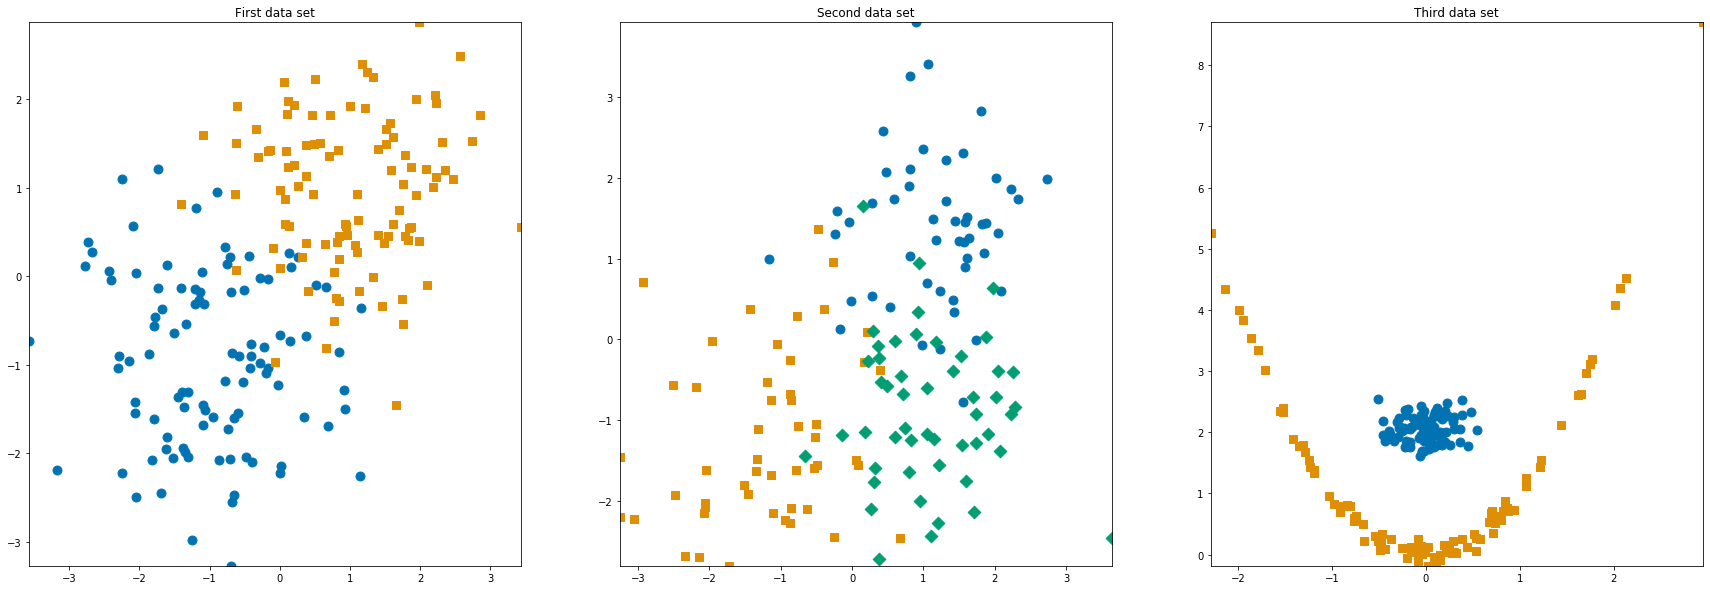

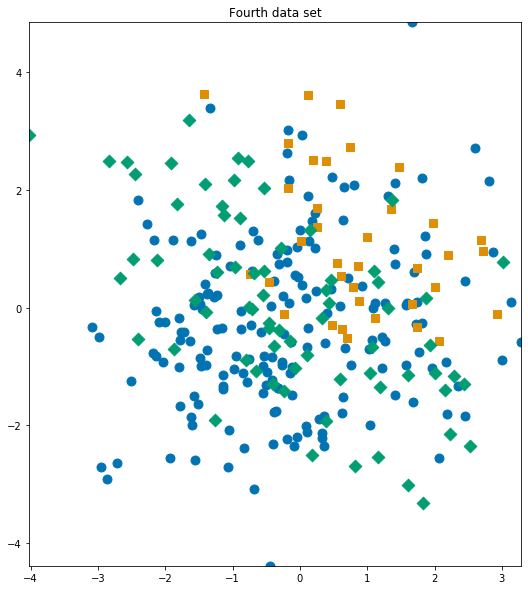

In [138]:
###############################################################################
#           Displaying labeled data
###############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=np.reshape(color_blind_list[i], (1, -1)), s=80,
                    marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

        
plt.close("all")
plt.figure(1, figsize=(30, 10))
plt.subplot(131)
plt.title('First data set')
plot_2d(X1, y1)
plt.subplot(132)
plt.title('Second data set')
plot_2d(X2, y2)
plt.subplot(133)
plt.title('Third data set')
plot_2d(X3, y3)
plt.show()
plt.figure(2, figsize=(30, 10))
plt.subplot(131)
plt.title('Fourth data set')
plot_2d(X4, y4)
plt.show()

## <center>- La méthode des k-plus proches voisins -</center>
### Approche intuitive
L’algorithme des $k$-plus proches voisins ($k-nn$ : pour $k-nearest neighbors$ en anglais) est un algorithme intuitif, aisément paramétrisable pour traiter un problème de classification avec un nombre quelconque d’étiquettes.                    
Le principe de l’algorithme est particulièrement simple : pour chaque nouveau point $x$ on commence par déterminer l’ensemble de ses $k$-plus proches voisins parmi les points d’apprentissage que l’on note $Vk(x)$ (bien sûr on doit choisir $1 ≤ k ≤ n$ pour que cela ait un sens). La classe que l’on affecte au nouveau point $x$ est alors la classe majoritaire dans l’ensemble $Vk(x)$. Une illustration de la méthode est donnée en Figure 1 pour le cas de trois classes.

#### 3) Proposons une version adaptée de cette méthode pour la régression, i.e., quand les observations $y$ sont à valeurs réelles : $Y = \mathbb{R}$.

=> Une version adaptée de cette méthode pour la régression serait d'utiliser la moyenne des classes sur les plus proches voisins du point considéré.

### Approche formelle
Pour définir précisément la méthode, il faut commencer par choisir une distance $d : \mathbb{R}^p \times \mathbb{R}^p \mapsto \mathbb{R}$

Pour un nouveau point $x$, on définit alors l’ensemble de ses $k$-plus proches voisins $Vk(x)$ au sens de de cette distance. 

#### 4) Écrivons notre propre classe `KNNClassifier` avec les méthodes d’apprentissage `fit` et de classification `predict`.
Nous choisirons une stratégie de traitement des ex aequo, c’est-à-dire des points avec la même distance ou le même nombre de points de chaque classe dans $Vk(x)$. Nous vérifierons la validité des résultats en les comparant à ceux de la classe `KNeighborsClassifier` de ***scikit-learn*** en utilisant le jeu de données #2. Nous porposerons notre propre méthode de comparaison (par exemple, en utilisant les observations d’indice pair pour le set d’apprentissage et celles d’indice impair pour le set de test).              

Pour plus d’information sur les classes on peut consulter par exemple http://docs.python.org/3/tutorial/classes.html.

In [152]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances

class KNNClassifier(BaseEstimator, ClassifierMixin):
#""" Homemade kNN classifier class """
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        dist =  pairwise_distances(X, self.X, 'euclidean')
        ind = np.argsort(dist, axis=1)
        y = np.zeros((X.shape[0],))
        
        for p in range(X.shape[0]):
            list_val = []
            for i in range(self.n_neighbors):
                #print(self.y[ind[0,i]])
                list_val.append(self.y[ind[p,i]])
            y[p] = Counter(list_val).most_common() [0][0]
        return y

In [155]:
classifier = KNNClassifier(n_neighbors=5)
classifier.fit(X2, y2)
#X0 = [[-1., -1.], [0., 0.]]
X0 = np.array([[-1., -1.], [0., 0.], [2., 2.], [2, -2]])
classifier.predict(X0)

array([2., 2., 1., 3.])

On obtient donc un tableau qui nous classifie les points \[-1, -1\], \[0, 0\], \[2, 2\], \[2, -2\] dans le deuxième jeu de données. Le résultat donne donc :
* \[-1, -1\] dans classe 2
* \[0, 0\] dans classe 2
* \[2, 2\] dans classe 1
* \[2, -2\] dans classe 3

In [158]:
from sklearn.neighbors import KNeighborsClassifier

neigh2 = KNeighborsClassifier(n_neighbors=5)
neigh2.fit(X2, y2) 
print(neigh2.predict([[-1., -1.], [0., 0.], [2., 2.], [2, -2]]))
#print(neigh.predict_proba([[0.9]]))

[2. 2. 1. 3.]


On retrouve bien les mêmes résultats que notre algorithme avec l'implémentation de `sklearn.neighbors`.

#### 5. Faisons tourner sur les quatre exemples de jeu de données cet algorithme de classification, en utilisant la distance euclidienne classique $d(x, v) = ||x − v||_2$ et $k = 5$. 
Visualisons les règles de classification obtenues en utilisant la fonction `frontiere_new`. (Souvent, les autres choix de distance peuvent être utiles, par exemple la distance de Mahalanobis.)

In [159]:
neigh1 = KNeighborsClassifier(n_neighbors=5)
neigh1.fit(X1, y1) 
print(neigh1.predict([[-1., -1.], [0., 0.], [2., 2.], [2, -2]]))

neigh3 = KNeighborsClassifier(n_neighbors=5)
neigh3.fit(X3, y3) 
print(neigh3.predict([[-1., -1.], [0., 0.], [2., 2.], [2, -2]]))

neigh4 = KNeighborsClassifier(n_neighbors=5)
neigh4.fit(X4, y4) 
print(neigh4.predict([[-1., -1.], [0., 0.], [2., 2.], [2, -2]]))

[-1. -1.  1. -1.]
[1. 1. 1. 1.]
[1. 1. 1. 1.]


In [172]:
###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, data, step=50, cmap_choice=cm.coolwarm, tiny=False):
    """ trace la frontiere pour la fonction de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap_choice)
    if tiny:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.colorbar()


def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter([X[i, 0]], [X[i, 1]], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)


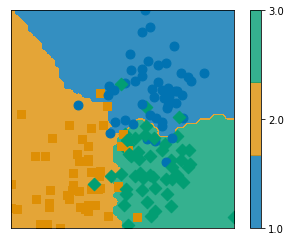

In [173]:
frontiere_new(neigh2.predict, X2, y2)

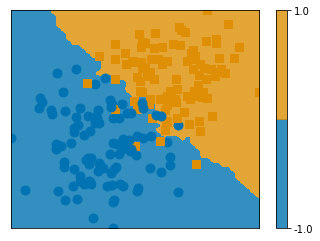

In [174]:
frontiere_new(neigh1.predict, X1, y1)

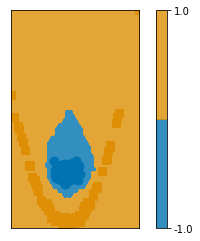

In [175]:
frontiere_new(neigh3.predict, X3, y3)

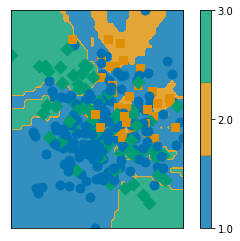

In [176]:
frontiere_new(neigh4.predict, X4, y4)

## 6. Pour les observations d’indice pair du jeu de données #2, faisons varier le nombre k de voisins pris en compte : $k = 1, 2, . . . , n$. 
Que devient la méthode dans le cas extrême où $k = 1$ ? $k = n$ ? Afficher ces cas sur les données étudiées en utilisant la fonction frontiere_new et présentez les dans une forme facilement lisible. Dans quels cas la frontière est-elle complexe ? simple ?

In [184]:
X2_pair = X2[::2, :]
print(X2.shape)
print(X2_pair.shape)

(150, 2)
(75, 2)


In [ ]:

###############################################################################
#               Algorithms and functions
###############################################################################


class ErrorCurve(object):
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, Xtest, ytest):
        def error_func(k):
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            knn.fit(X, y)
            error = np.mean(knn.predict(Xtest) != ytest)
            return error

        errors = list(map(error_func, self.k_range))
        self.errors = np.array(errors)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.errors, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Test error")
        if maketitle:
            plt.title("number of training points : %d" % len(self.y))


class LOOCurve(object):
    """Leave-One-Out (LOO) curve"""
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, n_iter=200, random_state=1):
        def score_func(k):
            n_samples = len(X)
            # Selon la verson de scikit-learn : shuffleSplit prend en argument
            # 'niter ' ou niterations'. De plus, l'argument test_size peut ne
            # pas etre reconnu. Il est recommande de consulter
            # help(model_selection.ShuffleSplit) pour connaitre la liste
            # des arguments reconnus par votre version de sickitlearn.
            loo = model_selection.ShuffleSplit(n_iter,
                                                test_size=1,
                                                train_size=n_samples-1,
                                                random_state=random_state)
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            scores = model_selection.cross_val_score(estimator=knn,
                                                      X=X, y=y,
                                                      cv=loo)
            return np.mean(scores)

        scores = list(map(score_func, self.k_range))
        self.cv_scores = np.array(scores)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.cv_scores, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Leave One Out Score (1-error rate)")
        if maketitle:
            plt.title("number of training points : %d" % (len(self.y) - 1))
